# Libraries

In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.ndimage import interpolation

# Splitting data into training and testing

In [9]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [11]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

# Creating a function for preprocessing images

In [13]:
def preprocess_digit(img):

    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img = img.astype("uint8")

    _, img = cv2.threshold(
        img, 0, 255,
        cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
    )

    coords = cv2.findNonZero(img)
    if coords is None:
        return np.zeros((28, 28, 1), dtype="float32")

    x, y, w, h = cv2.boundingRect(coords)
    digit = img[y:y+h, x:x+w]

    digit = cv2.resize(digit, (20, 20), interpolation=cv2.INTER_AREA)

    padded = np.pad(digit, ((4, 4), (4, 4)), "constant", constant_values=0)

    cy, cx = ndimage.measurements.center_of_mass(padded)
    rows, cols = padded.shape

    shift_x = int(np.round(cols/2 - cx))
    shift_y = int(np.round(rows/2 - cy))

    shifted = interpolation.shift(
        padded,
        shift=(shift_y, shift_x),
        mode='constant'
    )

    shifted = shifted.astype("float32") / 255.0

    shifted = shifted.reshape(28, 28, 1)

    return shifted

C:\Users\PARSEH\AppData\Local\Temp\ipykernel_9456\3609461004.py:29: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  cy, cx = ndimage.measurements.center_of_mass(padded)
C:\Users\PARSEH\AppData\Local\Temp\ipykernel_9456\3609461004.py:35: DeprecationWarning: Please import `shift` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  shifted = interpolation.shift(


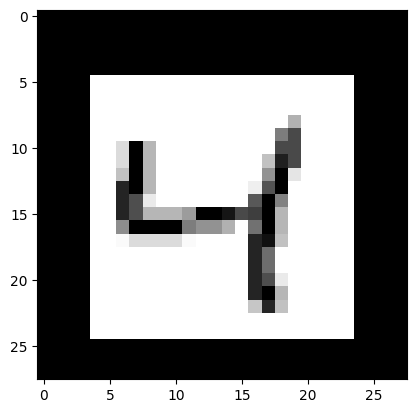

In [15]:
processed = preprocess_digit(x_train[2])
plt.imshow(processed.squeeze(), cmap='gray')
plt.show()

# Implementing a function on data

In [17]:
x_train_processed = np.array([preprocess_digit(img) for img in x_train])
x_test_processed  = np.array([preprocess_digit(img) for img in x_test])

print(x_train_processed.shape, x_test_processed.shape)

C:\Users\PARSEH\AppData\Local\Temp\ipykernel_9456\3609461004.py:29: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  cy, cx = ndimage.measurements.center_of_mass(padded)
C:\Users\PARSEH\AppData\Local\Temp\ipykernel_9456\3609461004.py:35: DeprecationWarning: Please import `shift` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  shifted = interpolation.shift(


(60000, 28, 28, 1) (10000, 28, 28, 1)


# Create Cnn Model

In [37]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),

    layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

C:\Users\PARSEH\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 26, 26, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 11, 11, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 3, 3, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 242,954 (949.04 KB)

 Trainable params: 242,250 (946.29 KB)

 Non-trainable params: 704 (2.75 KB)

# Fitting the model to the data

In [39]:
history = model.fit(
    x_train_processed, y_train,
    epochs=8,
    batch_size=64,
    validation_data=(x_test_processed, y_test)
)

Epoch 1/8
938/938 ━━━━━━━━━━━━━━━━━━━━ 65s 65ms/step - accuracy: 0.9585 - loss: 0.1382 - val_accuracy: 0.9750 - val_loss: 0.0811
Epoch 2/8
938/938 ━━━━━━━━━━━━━━━━━━━━ 65s 69ms/step - accuracy: 0.9831 - loss: 0.0582 - val_accuracy: 0.9875 - val_loss: 0.0399
Epoch 3/8
938/938 ━━━━━━━━━━━━━━━━━━━━ 69s 55ms/step - accuracy: 0.9874 - loss: 0.0416 - val_accuracy: 0.9851 - val_loss: 0.0439
Epoch 4/8
938/938 ━━━━━━━━━━━━━━━━━━━━ 63s 67ms/step - accuracy: 0.9890 - loss: 0.0362 - val_accuracy: 0.9853 - val_loss: 0.0479
Epoch 5/8
938/938 ━━━━━━━━━━━━━━━━━━━━ 54s 58ms/step - accuracy: 0.9913 - loss: 0.0275 - val_accuracy: 0.9854 - val_loss: 0.0509
Epoch 6/8
938/938 ━━━━━━━━━━━━━━━━━━━━ 116s 94ms/step - accuracy: 0.9927 - loss: 0.0237 - val_accuracy: 0.9779 - val_loss: 0.0714
Epoch 7/8
938/938 ━━━━━━━━━━━━━━━━━━━━ 57s 60ms/step - accuracy: 0.9940 - loss: 0.0195 - val_accuracy: 0.9883 - val_loss: 0.0402
Epoch 8/8
938/938 ━━━━━━━━━━━━━━━━━━━━ 64s 68ms/step - accuracy: 0.9941 - loss: 0.0185 - val_acc

# Saving the model

In [41]:
model.save("digit_cnn.h5")

# Load the model

In [23]:
model = load_model("digit_cnn.h5")

# Camera access

In [35]:
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    H, W, _ = frame.shape

    box_size = 250
    cx, cy = W // 2, H // 2
    x1 = cx - box_size // 2
    y1 = cy - box_size // 2
    x2 = cx + box_size // 2
    y2 = cy + box_size // 2

    cv2.rectangle(frame, (x1, y1), (x2, y2), (0,255,0), 3)

    roi = frame[y1:y2, x1:x2]

    processed = preprocess_digit(roi)

    input_tensor = processed.reshape(1, 28, 28, 1)
    preds = model.predict(input_tensor, verbose=0)
    digit = np.argmax(preds)
    confidence = np.max(preds) * 100

    text = f"Prediction: {digit}   ({confidence:.1f}%)"
    cv2.putText(frame, text, (40, 80),
                cv2.FONT_HERSHEY_SIMPLEX,
                1.2, (0, 255, 255), 3)

    preview = (processed.squeeze() * 255).astype("uint8")
    preview = cv2.resize(preview, (100, 100), interpolation=cv2.INTER_NEAREST)
    preview = cv2.cvtColor(preview, cv2.COLOR_GRAY2BGR)

    frame[20:120, W-120:W-20] = preview

    cv2.putText(frame, "Processed", (W-140, 15),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)

    cv2.imshow("Digit Recognition", frame)

    if cv2.waitKey(1) & 0xFF == 27:
        break

cap.release()
cv2.destroyAllWindows()

C:\Users\PARSEH\AppData\Local\Temp\ipykernel_9456\3609461004.py:29: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  cy, cx = ndimage.measurements.center_of_mass(padded)
C:\Users\PARSEH\AppData\Local\Temp\ipykernel_9456\3609461004.py:35: DeprecationWarning: Please import `shift` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  shifted = interpolation.shift(
